<a href="https://colab.research.google.com/github/tirals88/predicting_pm2.5/blob/main/data/AIFactory(AI_SPARK_%EC%B1%8C%EB%A6%B0%EC%A7%80_%EC%82%AC%ED%9A%8C%EB%AC%B8%EC%A0%9C%ED%95%B4%EA%B2%B0%ED%98%95)_%EB%8D%B0%EC%9D%B4%ED%84%B0_%EB%B6%84%EC%84%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 지역사회 대기오염 예측 인공지능 모델 개발

목표 : 대전/세종/충남 지역 초미세먼지(**PM2.5**) 오염도를 시간단위로 예측하는 모델 개발

데이터의 연도/시간/값은 비식별화 되어있음

AWS : 지역별 상세 관측자료

## 모델 조건

1. 2일 분량의 PM2.5 / AWS 데이터(test set)와 과거 기간의 PM2.5 / AWS 데이터(train set)을 활용하여 3일 분량의 지역별 시간당 PM2.5 값을 예측한다.

2. PM2.5 예측에 AWS 값이 반드시 사용되어야함

# 데이터 구성

- TRAIN / TRAIN_AWS : 학습용 PM2.5 데이터 / 학습용 기상조건 데이터

- TEST_INPUT / TEST_AWS : 평가용 PM2.5 데이터 / 평가용 기상조건 데이터

- META : PM2.5 관측소 및 AWS 관측소 위치정보

- answer_sample.csv - 정답 양식 파일

In [ ]:
# 데이터 확인
import os
data = '/content/drive/MyDrive/AIFactory/dataset'
file_type = ['/TRAIN', '/TRAIN_AWS', '/TEST_INPUT', '/TEST_AWS']
train_list = os.listdir(data+file_type[0])
train_AWS_list = os.listdir(data+file_type[1])

print(train_list)
print(train_AWS_list)

print("Train_list : {}".format(len(train_list)))
print("Train_AWS_list : {}".format(len(train_AWS_list)))

['공주.csv', '읍내동.csv', '신흥동.csv', '모종동.csv', '문창동.csv', '정림동.csv', '신방동.csv', '독곶리.csv', '이원면.csv', '성성동.csv', '노은동.csv', '아름동.csv', '홍성읍.csv', '대천2동.csv', '동문동.csv', '예산군.csv', '논산.csv']
['공주.csv', '계룡.csv', '논산.csv', '성거.csv', '북격렬비도.csv', '세종고운.csv', '당진.csv', '세천.csv', '정산.csv', '대산.csv', '세종연서.csv', '세종금남.csv', '청양.csv', '세종전의.csv', '아산.csv', '유구.csv', '서천.csv', '양화.csv', '장동.csv', '정안.csv', '대천항.csv', '예산.csv', '안도.csv', '옹도.csv', '오월드.csv', '호도.csv', '춘장대.csv', '태안.csv', '홍북.csv', '홍성죽도.csv']
Train_list : 17
Train_AWS_list : 30


In [ ]:
import pandas as pd

for i in range(len(train_list)):
  globals()["train_{}".format(i)] = pd.read_csv(data+file_type[0]+'/'+train_list[i]) #names = ["year", "date-time", "obs", "PM2.5"]
  print(globals()["train_{}".format(i)].info())

In [ ]:
for i in range(len(train_list)):
  print(globals()["train_{}".format(i)]['PM2.5'].describe())
  print('\n\n')

In [ ]:
#train_AWS

for i in range(len(train_AWS_list)):
  globals()["train_AWS_{}".format(i)] = pd.read_csv(data+file_type[1]+'/'+train_AWS_list[i])
  print(globals()["train_AWS_{}".format(i)].info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   연도       35064 non-null  int64  
 1   일시       35064 non-null  object 
 2   지점       35064 non-null  object 
 3   기온(°C)   34380 non-null  float64
 4   풍향(deg)  34380 non-null  float64
 5   풍속(m/s)  34380 non-null  float64
 6   강수량(mm)  34380 non-null  float64
 7   습도(%)    34380 non-null  float64
dtypes: float64(5), int64(1), object(2)
memory usage: 2.1+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   연도       35064 non-null  int64  
 1   일시       35064 non-null  object 
 2   지점       35064 non-null  object 
 3   기온(°C)   34000 non-null  float64
 4   풍향(deg)  34000 non-null  float64
 5   풍속(m/s)  34000 non-null  float64
 6   강수량(mm)  34000 non-null  flo

##PM2.5
관측소 수 : 17

관측소 당 데이터 수 : 35064

##AWS
관측소 수 : 30

관측소 당 데이터 수 : 35064

PM2.5 관측지점과 AWS 관측지점의 위치가 다르기 때문에 PM2.5에 영향을 주는 기상조건을 산출하기 위해서는 META로 제공되는 위치 정보를 활용할 수 있어야 합니다.


위치 정보를 이용해 가까운 관측소와 비교적 먼 관측소가 PM2.5 값에 미치는 영향의 차이가 있는지 확인하고 싶음

-> PM2.5 관측지점 하나를 정해서, 그 지점과 가까운 AWS 관측소 두 곳, 먼 관측소 두 곳을 지정해서 heatmap 활용

- PM2.5 관측소 : 신방동 (36.7823546,	127.1205056)
-  AWS 관측소 1: 성거 (36.8782,	127.1561) // **0.1022413908968373**
-  AWS 관측소 2: 세종전의 (36.6908,	127.2005) //  **0.12157857053165125**

<img src='https://drive.google.com/uc?export=download&id=1K3_HKCqZrAaqe8vR1UrpXZsMDzHsKfFm' width="400" height ="" /><br>

- AWS 관측소 3 : 태안 (36.7585,	126.2964) //  **0.8244507759063079**
- AWS 관측소 4 : 춘장대 (36.1741,	126.5285) //  **0.8487898967662861**

<img src='https://drive.google.com/uc?export=download&id=1hgBbtTnlzM7dqlZvRp_HK-mlezEy0pCd' width="400" height ="" /><br>

In [ ]:
import numpy as np

a1 = np.array([36.7823546, 127.1205056])
b1 = np.array([36.8782, 127.1561])
b2 = np.array([36.6908, 127.2005])
b3 = np.array([36.7585, 126.2964])
b4 = np.array([36.1741, 126.5285])

d1 = np.linalg.norm(a1-b1)
d2 = np.linalg.norm(a1-b2)
d3 = np.linalg.norm(a1-b3)
d4 = np.linalg.norm(a1-b4)

print(d1, d2, d3, d4)

0.1022413908968373 0.12157857053165125 0.8244507759063079 0.8487898967662861


5개의 데이터의 null data 를 평균값으로 대체 / PM2.5 관측소(신방동)과 각 4개의 AWS 관측소 간의 heatmap (PM2.5 - [기온/풍향/풍속/강수량/습도]) 확인

In [ ]:
temp_pm = pd.read_csv(data+file_type[0]+'/신방동.csv')
temp_pm = temp_pm.fillna({'PM2.5':temp_pm['PM2.5'].mean()})
temp_pm.isnull().sum()

연도       0
일시       0
측정소      0
PM2.5    0
dtype: int64

In [ ]:
temp_aws1 = pd.read_csv(data+file_type[1]+'/성거.csv')
temp_aws1 = temp_aws1.fillna({'기온(°C)':temp_aws1['기온(°C)'].mean()})
temp_aws1 = temp_aws1.fillna({'풍향(deg)':temp_aws1['풍향(deg)'].mean()})
temp_aws1 = temp_aws1.fillna({'풍속(m/s)':temp_aws1['풍속(m/s)'].mean()})
temp_aws1 = temp_aws1.fillna({'강수량(mm)':temp_aws1['강수량(mm)'].mean()})
temp_aws1 = temp_aws1.fillna({'습도(%)':temp_aws1['습도(%)'].mean()})
temp_aws1.isnull().sum()

연도         0
일시         0
지점         0
기온(°C)     0
풍향(deg)    0
풍속(m/s)    0
강수량(mm)    0
습도(%)      0
dtype: int64

In [ ]:
temp1 = pd.concat([temp_pm['PM2.5'], temp_aws1['기온(°C)'], temp_aws1['풍향(deg)'],
                   temp_aws1['풍속(m/s)'], temp_aws1['강수량(mm)'], temp_aws1['습도(%)']], axis = 1)
temp1

,PM2.5,기온(°C),풍향(deg),풍속(m/s),강수량(mm),습도(%)
0,0.056,0.157978,0.012500,0.012788,0.0,0.615
1,0.048,0.153239,0.000000,0.007673,0.0,0.593
2,0.048,0.137441,0.000000,0.010230,0.0,0.674
3,0.056,0.115324,0.000000,0.010230,0.0,0.705
4,0.044,0.112164,0.000000,0.000000,0.0,0.732
...,...,...,...,...,...,...
35059,0.076,0.271722,0.867778,0.043478,0.0,0.534
35060,0.068,0.260664,0.907500,0.035806,0.0,0.568
35061,0.080,0.246445,0.043889,0.023018,0.0,0.537
35062,0.072,0.236967,0.003889,0.025575,0.0,0.542


['NanumGothic']


/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.draw()


<Axes: >

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


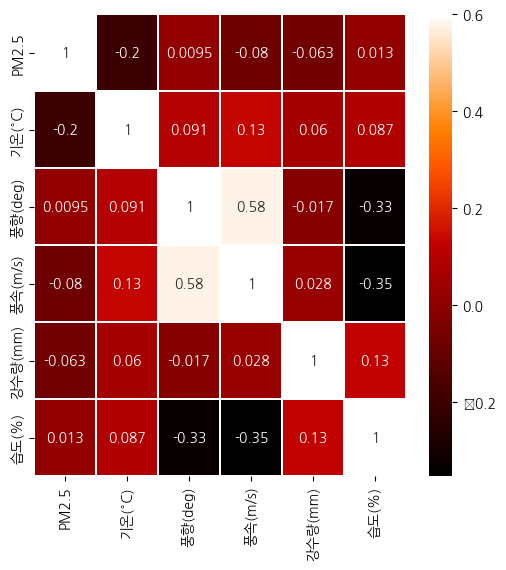

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 6))
plt.rcParams['font.family'] = 'NanumGothic'
print(plt.rcParams['font.family'])

sns.heatmap(temp1.corr(), linewidths=.1, vmax=.6, cmap=plt.cm.gist_heat,
            linecolor='white', annot=True)

### PM2.5 와 AWS 수치 간의 직접적인 연관성을 찾기는 힘듦

In [ ]:
temp_aws3 = pd.read_csv(data+file_type[1]+'/태안.csv')
temp_aws3 = temp_aws3.fillna({'기온(°C)':temp_aws3['기온(°C)'].mean()})
temp_aws3 = temp_aws3.fillna({'풍향(deg)':temp_aws3['풍향(deg)'].mean()})
temp_aws3 = temp_aws3.fillna({'풍속(m/s)':temp_aws3['풍속(m/s)'].mean()})
temp_aws3 = temp_aws3.fillna({'강수량(mm)':temp_aws3['강수량(mm)'].mean()})
temp_aws3 = temp_aws3.fillna({'습도(%)':temp_aws3['습도(%)'].mean()})
temp_aws3.isnull().sum()

연도         0
일시         0
지점         0
기온(°C)     0
풍향(deg)    0
풍속(m/s)    0
강수량(mm)    0
습도(%)      0
dtype: int64

/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.draw()


<Axes: >

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


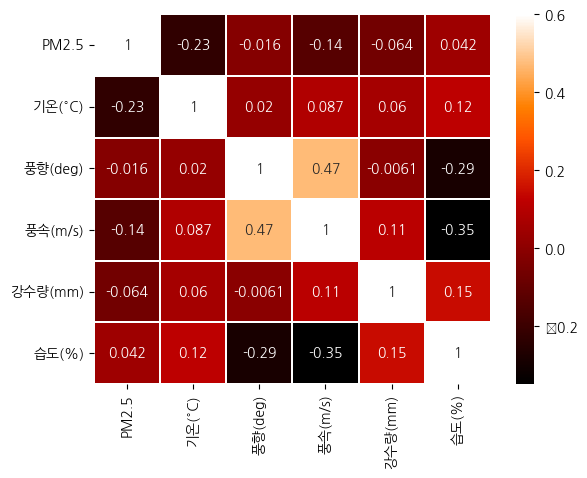

In [ ]:
temp3 = pd.concat([temp_pm['PM2.5'], temp_aws3['기온(°C)'], temp_aws3['풍향(deg)'],
                   temp_aws3['풍속(m/s)'], temp_aws3['강수량(mm)'], temp_aws3['습도(%)']], axis = 1)

sns.heatmap(temp3.corr(), linewidths=.1, vmax=.6, cmap=plt.cm.gist_heat,
            linecolor='white', annot=True)

### temp1 (비교적 가까운 AWS 관측소) / temp3 (비교적 먼 AWS 관측소) 간의 차이가 크게 없지만, temp1의 연관성이 미세하게 높음

In [ ]:
temp_aws2 = pd.read_csv(data+file_type[1]+'/세종전의.csv')
temp_aws2 = temp_aws2.fillna({'기온(°C)':temp_aws2['기온(°C)'].mean()})
temp_aws2 = temp_aws2.fillna({'풍향(deg)':temp_aws2['풍향(deg)'].mean()})
temp_aws2 = temp_aws2.fillna({'풍속(m/s)':temp_aws2['풍속(m/s)'].mean()})
temp_aws2 = temp_aws2.fillna({'강수량(mm)':temp_aws2['강수량(mm)'].mean()})
temp_aws2 = temp_aws2.fillna({'습도(%)':temp_aws2['습도(%)'].mean()})
temp_aws2.isnull().sum()

temp_aws4 = pd.read_csv(data+file_type[1]+'/춘장대.csv')
temp_aws4 = temp_aws4.fillna({'기온(°C)':temp_aws4['기온(°C)'].mean()})
temp_aws4 = temp_aws4.fillna({'풍향(deg)':temp_aws4['풍향(deg)'].mean()})
temp_aws4 = temp_aws4.fillna({'풍속(m/s)':temp_aws4['풍속(m/s)'].mean()})
temp_aws4 = temp_aws4.fillna({'강수량(mm)':temp_aws4['강수량(mm)'].mean()})
temp_aws4 = temp_aws4.fillna({'습도(%)':temp_aws4['습도(%)'].mean()})
temp_aws4.isnull().sum()

연도         0
일시         0
지점         0
기온(°C)     0
풍향(deg)    0
풍속(m/s)    0
강수량(mm)    0
습도(%)      0
dtype: int64

In [ ]:
temp2 = pd.concat([temp_pm['PM2.5'], temp_aws2['기온(°C)'], temp_aws2['풍향(deg)'],
                   temp_aws2['풍속(m/s)'], temp_aws2['강수량(mm)'], temp_aws2['습도(%)']], axis = 1)

temp4 = pd.concat([temp_pm['PM2.5'], temp_aws4['기온(°C)'], temp_aws4['풍향(deg)'],
                   temp_aws4['풍속(m/s)'], temp_aws4['강수량(mm)'], temp_aws4['습도(%)']], axis = 1)

temp1.corr()

,PM2.5,기온(°C),풍향(deg),풍속(m/s),강수량(mm),습도(%)
PM2.5,1.000000,-0.200499,0.009518,-0.079999,-0.062920,0.012591
기온(°C),-0.200499,1.000000,0.090523,0.133901,0.059795,0.086748
풍향(deg),0.009518,0.090523,1.000000,0.576794,-0.016542,-0.330544
풍속(m/s),-0.079999,0.133901,0.576794,1.000000,0.027526,-0.352061
강수량(mm),-0.062920,0.059795,-0.016542,0.027526,1.000000,0.125580
습도(%),0.012591,0.086748,-0.330544,-0.352061,0.125580,1.000000


In [ ]:
temp2.corr()

,PM2.5,기온(°C),풍향(deg),풍속(m/s),강수량(mm),습도(%)
PM2.5,1.000000,-0.203608,-0.028343,-0.095568,-0.068510,-0.051319
기온(°C),-0.203608,1.000000,0.137220,0.221356,0.065696,-0.044983
풍향(deg),-0.028343,0.137220,1.000000,0.515673,0.008677,-0.382855
풍속(m/s),-0.095568,0.221356,0.515673,1.000000,0.053178,-0.530083
강수량(mm),-0.068510,0.065696,0.008677,0.053178,1.000000,0.118636
습도(%),-0.051319,-0.044983,-0.382855,-0.530083,0.118636,1.000000


In [ ]:
temp3.corr()

,PM2.5,기온(°C),풍향(deg),풍속(m/s),강수량(mm),습도(%)
PM2.5,1.000000,-0.226316,-0.016488,-0.135482,-0.063872,0.041798
기온(°C),-0.226316,1.000000,0.020492,0.087103,0.060420,0.119702
풍향(deg),-0.016488,0.020492,1.000000,0.471851,-0.006103,-0.287178
풍속(m/s),-0.135482,0.087103,0.471851,1.000000,0.111351,-0.347809
강수량(mm),-0.063872,0.060420,-0.006103,0.111351,1.000000,0.145628
습도(%),0.041798,0.119702,-0.287178,-0.347809,0.145628,1.000000


In [ ]:
temp4.corr()

,PM2.5,기온(°C),풍향(deg),풍속(m/s),강수량(mm),습도(%)
PM2.5,1.000000,-0.251947,0.004447,-0.165931,-0.066135,0.005076
기온(°C),-0.251947,1.000000,0.094405,-0.091363,0.072824,0.226472
풍향(deg),0.004447,0.094405,1.000000,0.391535,-0.034710,-0.297403
풍속(m/s),-0.165931,-0.091363,0.391535,1.000000,0.098712,-0.279034
강수량(mm),-0.066135,0.072824,-0.034710,0.098712,1.000000,0.128851
습도(%),0.005076,0.226472,-0.297403,-0.279034,0.128851,1.000000


<Axes: >

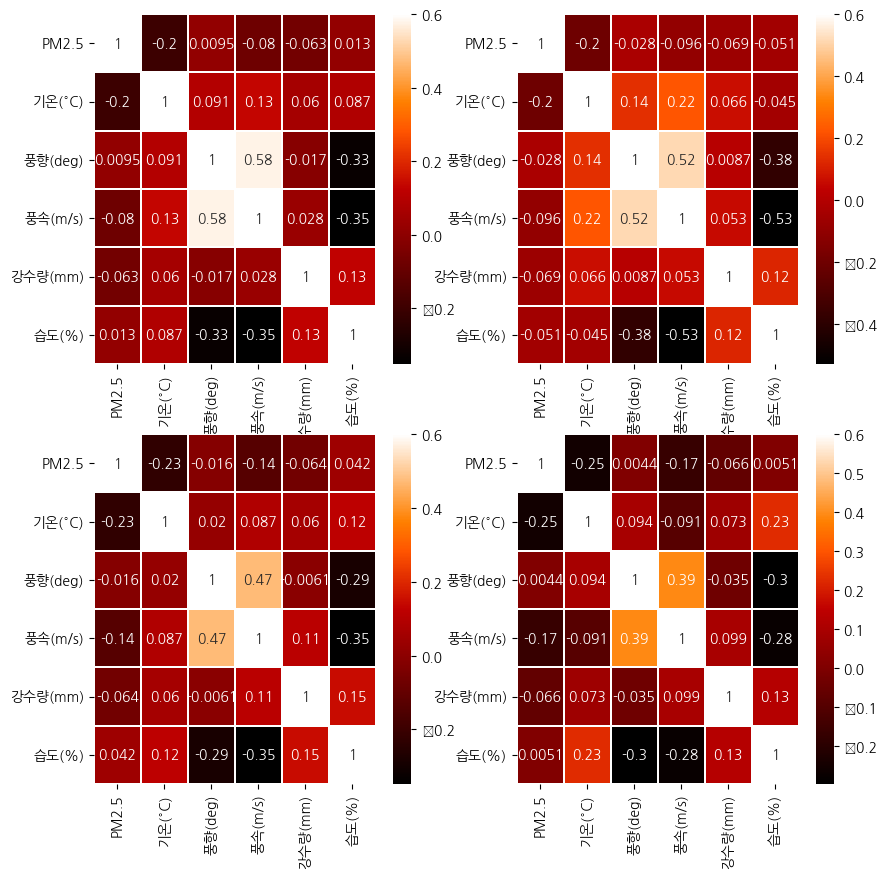

In [ ]:
plt.figure(figsize=(10, 10))

#성거
plt.subplot(2, 2, 1)
sns.heatmap(temp1.corr(), linewidths=.1, vmax=.6, cmap=plt.cm.gist_heat,
            linecolor='white', annot=True)
#세종전의
plt.subplot(2, 2, 2)
sns.heatmap(temp2.corr(), linewidths=.1, vmax=.6, cmap=plt.cm.gist_heat,
            linecolor='white', annot=True)
#태안
plt.subplot(2, 2, 3)
sns.heatmap(temp3.corr(), linewidths=.1, vmax=.6, cmap=plt.cm.gist_heat,
            linecolor='white', annot=True)
#춘장대
plt.subplot(2, 2, 4)
sns.heatmap(temp4.corr(), linewidths=.1, vmax=.6, cmap=plt.cm.gist_heat,
            linecolor='white', annot=True)

영향이 없는 것 같음.
애초에 시계열적 연속성이 아닌 순간의 수치만을 비교한 heatmap 자체가 적절하지 않았을수도 있음